演習課題：サイコロの目の認識AIの構築

dice-04.ipynb : ディープニューラルネットワークによるサイコロ画像の学習・評価

カラー画像を入力とする学習モデルを構築します

In [2]:
# Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

# OpenCV imshowサポートパッチのインポート
from google.colab.patches import cv2_imshow

# ライブラリインポート
import os # ファイル操作関係
import re # 文字列処理
import cv2 # 画像処理
import numpy as np # 配列処理
import datetime
from pytz import timezone
import joblib # 学習モデル保存
import random # 乱数生成
import matplotlib.pyplot as plt # グラフ描画
from sklearn import model_selection # Scikit Learn
import tensorflow as tf # テンソルフロー
import keras
from tensorflow.keras.models import Sequential # Keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping

Mounted at /content/drive


['rgb-dice-1-20250514-110832.jpg', 'rgb-dice-1-20250514-110746.jpg', 'rgb-dice-1-20250514-110811.jpg', 'rgb-dice-1-20250514-110852.jpg', 'rgb-dice-1-20250514-110905.jpg', 'rgb-dice-2-20250514-110945.jpg', 'rgb-dice-2-20250514-111032.jpg', 'rgb-dice-2-20250514-111008.jpg', 'rgb-dice-2-20250514-111041.jpg', 'rgb-dice-2-20250514-111056.jpg', 'rgb-dice-3-20250514-111128.jpg', 'rgb-dice-3-20250514-111143.jpg', 'rgb-dice-3-20250514-111211.jpg', 'rgb-dice-3-20250514-111224.jpg', 'rgb-dice-3-20250514-111241.jpg', 'rgb-dice-4-20250514-111258.jpg', 'rgb-dice-4-20250514-111309.jpg', 'rgb-dice-4-20250514-111328.jpg', 'rgb-dice-4-20250514-111337.jpg', 'rgb-dice-4-20250514-111347.jpg', 'rgb-dice-5-20250514-111359.jpg', 'rgb-dice-5-20250514-111413.jpg', 'rgb-dice-5-20250514-111425.jpg', 'rgb-dice-5-20250514-111434.jpg', 'rgb-dice-5-20250514-111443.jpg', 'rgb-dice-6-20250514-111456.jpg', 'rgb-dice-6-20250514-111506.jpg', 'rgb-dice-6-20250514-111524.jpg', 'rgb-dice-6-20250514-111537.jpg', 'rgb-dice-6-2

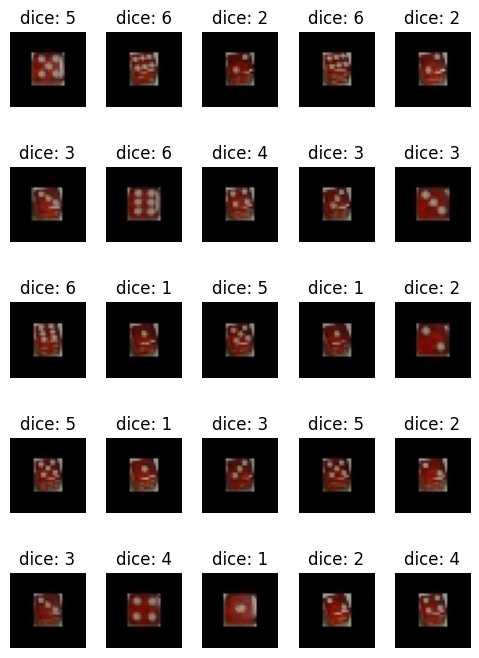

In [3]:
#入力画像サイズ
size_w = 32     # width
size_h = 32     # height

# 現在時刻取得
time_zone = timezone('Asia/Tokyo')
time_now = datetime.datetime.now(time_zone)
save_time = time_now.strftime('%Y%m%d-%H%M%S')
# 学習モデルの保存ファイル名
model_filename = save_time + "DNN.keras"

# x: 入力データベクトル、y：教師データベクトル
x = np.empty((0, size_w, size_h, 3), float)
y = np.array([], int)

# 読み込みフォルダパス
directory_name = '/content/drive/MyDrive/Colab Notebooks/AI-Kouza/dataset/img_dice_rgb/'
# フォルダ内のファイル名を全て取得
file_list = os.listdir(directory_name)
print(file_list)
print('File number: {}'.format(len(file_list)))

# 保存先フォルダが存在しなかったら新規作成
# 学習モデル
directory_save_model = '/content/drive/MyDrive/Colab Notebooks/AI-Kouza/model_save/'
if not os.path.exists(directory_save_model):
  os.mkdir(directory_save_model)

# 画像データ読み込み
count_load = 0
for i, file_name in enumerate(file_list):
  if re.search('\.jpg', file_name): # jpgファイルのみ処理
    img = cv2.imread(directory_name + file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array([img/255.0])
    x = np.append(x, np.reshape(img, (1,size_w, size_h, 3)), axis=0) # 画像（RGB 3チャンネル）
    dice_num = int(file_name[9])
    y = np.append(y, dice_num - 1) # サイコロ番号(0～5: Kerasの仕様に合わせる)
    count_load += 1

print('Loaded: {}'.format(count_load))

# 読み込み画像をランダムに選択して表示 25枚
fig = plt.figure(figsize=(6.0,8.0))
if(count_load < 25):
  for i in range(count_load):
    ax = fig.add_subplot(5, 5, i+1)
    ax.set_title("dice: {}".format(y[i]+1))
    ax.axis( "off" )
    plt.imshow(x[i])
  plt.subplots_adjust(hspace=0.8)
  plt.show()
else:
  select25 = random.sample(range(0, count_load), 25)
  for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.set_title("dice: {}".format(y[select25[i]]+1))
    ax.axis( "off" )
    plt.imshow(x[select25[i]])
  plt.subplots_adjust(hspace=0.8)
  plt.show()

ディープニューラルネットワーク（CNN）で学習モデルを構築します

CNN2層，全結合層2層

層数は簡単に増やせるので試してみてください

channels_last
Epoch 1/100
3/3 - 2s - 577ms/step - accuracy: 0.1333 - loss: 1.8145
Epoch 2/100
3/3 - 0s - 62ms/step - accuracy: 0.1667 - loss: 1.7860
Epoch 3/100
3/3 - 0s - 99ms/step - accuracy: 0.5000 - loss: 1.7384
Epoch 4/100
3/3 - 0s - 101ms/step - accuracy: 0.4667 - loss: 1.6771
Epoch 5/100
3/3 - 0s - 137ms/step - accuracy: 0.6333 - loss: 1.5857
Epoch 6/100
3/3 - 1s - 209ms/step - accuracy: 0.6333 - loss: 1.4796
Epoch 7/100
3/3 - 0s - 105ms/step - accuracy: 0.7667 - loss: 1.3756
Epoch 8/100
3/3 - 0s - 103ms/step - accuracy: 0.7333 - loss: 1.1989
Epoch 9/100
3/3 - 1s - 210ms/step - accuracy: 0.8667 - loss: 1.0367
Epoch 10/100
3/3 - 1s - 209ms/step - accuracy: 0.8667 - loss: 0.8419
Epoch 11/100
3/3 - 0s - 109ms/step - accuracy: 0.9000 - loss: 0.6890
Epoch 12/100
3/3 - 0s - 106ms/step - accuracy: 0.8667 - loss: 0.5826
Epoch 13/100
3/3 - 1s - 167ms/step - accuracy: 0.8333 - loss: 0.5700
Epoch 14/100
3/3 - 0s - 62ms/step - accuracy: 1.0000 - loss: 0.2835
Epoch 15/100
3/3 - 0s - 67ms/ste

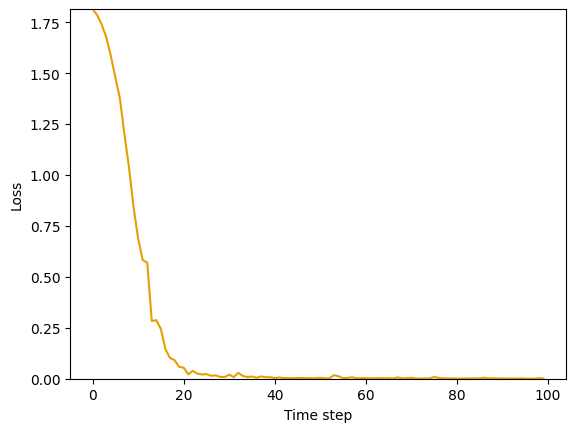

In [29]:
# keras用のパラメータ
# 学習回数
epochs = 100
# バッチサイズ
batch_size = 10
# クラス数
n_classes = 6

# クラスデータyをOne-hotベクトルに変換
y_keras = utils.to_categorical(y, n_classes)
# 入力形状
input_shape = (size_h, size_w, 3)
# keras内処理のチャネル位置確認
print(tf.keras.backend.image_data_format())

# 畳み込みニューラルネットワークを定義
model = Sequential()
model.add(layers.Input(shape=input_shape))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=n_classes, activation='softmax'))

# モデルのコンパイル
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
# モデルの学習
history = model.fit(x, y_keras, batch_size=batch_size, epochs=epochs, validation_split=0., verbose=2)
# 結果の表示
result_loss, result_acc = model.evaluate(x, y_keras, verbose=0)

# 正解率をパーセント表示
print('Accuracy: {:.3f} [%]'.format(result_acc*100))

# 学習結果を保存
model.save(directory_save_model + model_filename)
print('学習結果はファイル{0}に保存されました'.format(model_filename))

# 損失関数のグラフの軸ラベルを設定
plt.xlabel('Time step')
plt.ylabel('Loss')
# グラフ縦軸の範囲を0以上loss最大値以下に設定
plt.ylim(0, max(history.history['loss']))
# 損失関数の時間変化を描画
plt.plot(history.history['loss'], c='#E69F00')
# 描画したグラフを表示
plt.show()

学習後のモデルの精度（Accuracy）を確認します

ここで使用するデータは学習に用いた画像データです（学習データに対してどれほど学習できているかを確認するため）

結果で表示される画像のTrueは正解のサイコロ番号，Outputはモデルによる分類結果です

Accuracy: 100.000 [%]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


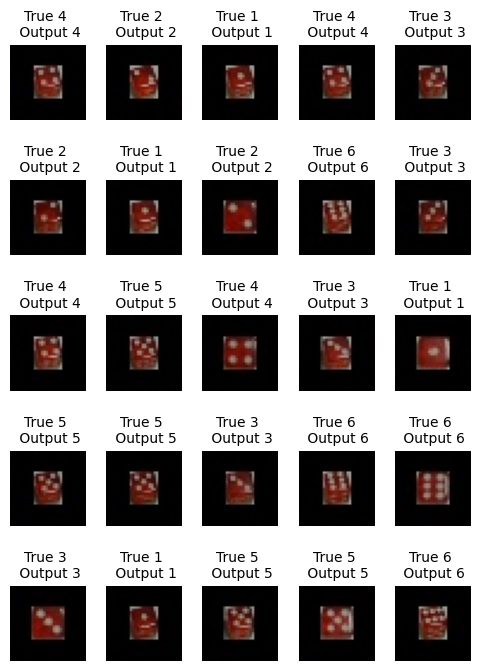

In [27]:
# 正解率をパーセント表示
print('Accuracy: {:.3f} [%]'.format(result_acc*100))

# 画像をランダムに選択して分類結果を表示 25枚
fig = plt.figure(figsize=(6.0,8.0))
if(count_load < 25):
  for i in range(count_load):
    result_tmp = model.predict(x[i]) # 分類結果取得
    result = np.argmax(result_tmp)
    ax = fig.add_subplot(5, 5, i+1)
    ax.set_title("True {0} \n Output {1}".format(y[i]+1, result+1), fontsize=10)
    ax.axis( "off" )
    plt.imshow(x[i].reshape(size_h, size_w, 3))
  plt.subplots_adjust(hspace=0.8)
  plt.show()
else:
  select25 = random.sample(range(0, count_load), 25)
  result_tmp = model.predict(x[select25]) # 分類結果取得
  result = result_tmp
  for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.set_title("True {0} \n Output {1}".format(y[select25[i]]+1, np.argmax(result[i])+1), fontsize=10)
    ax.axis( "off" )
    plt.imshow(x[select25[i]].reshape(size_h, size_w, 3))
  plt.subplots_adjust(hspace=0.8)
  plt.show()

評価用のデータを読み込んで学習済みモデルの性能を評価します

Loaded: 120
Accuracy: 48.333 [%]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


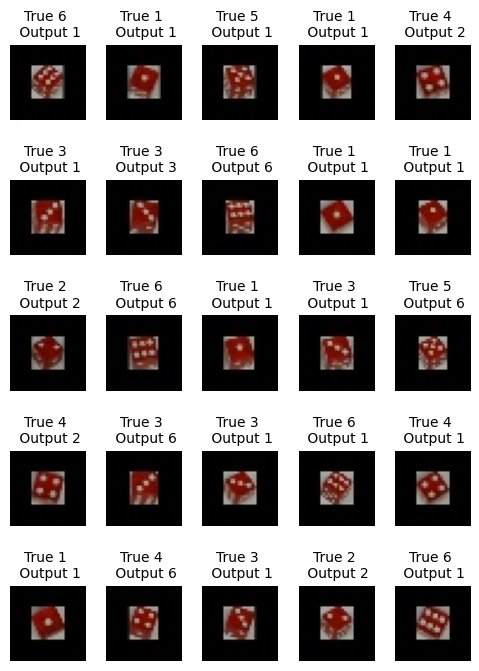

In [28]:
# 読み込みフォルダパス
directory_name = '/content/drive/MyDrive/Colab Notebooks/AI-Kouza/dataset/img_dice_rgb_test/'
# フォルダ内のファイル名を全て取得
file_list = os.listdir(directory_name)

# 画像データ読み込み
count_load_test = 0
x_test = np.empty((0, size_w, size_h, 3), float) # 初期化
y_test = np.array([], int)
for i, file_name in enumerate(file_list):
  if re.search('\.jpg', file_name): # jpgファイルのみ処理
    img = cv2.imread(directory_name + file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array([img/255.0])
    x_test = np.append(x_test, np.reshape(img, (1,size_w, size_h, 3)), axis=0) # 画像（RGB 3チャンネル）
    dice_num = int(file_name[9])
    y_test = np.append(y_test, dice_num - 1) # サイコロ番号(0～5: Kerasの仕様に合わせる)
    count_load_test += 1

print('Loaded: {}'.format(count_load_test))

# 分類結果取得
y_keras_test = utils.to_categorical(y_test, n_classes) # クラスデータyをOne-hotベクトルに変換
result_loss, result_acc = model.evaluate(x_test, y_keras_test, verbose=0)

# 正解率をパーセント表示
print('Accuracy: {:.3f} [%]'.format(result_acc*100))

# 評価画像をランダムに選択して分類結果を表示 25枚
fig = plt.figure(figsize=(6.0,8.0))
if(count_load_test < 25):
  for i in range(count_load_test):
    result_tmp = model.predict(x_test[i]) # 分類結果取得
    result = np.argmax(result_tmp)
    ax = fig.add_subplot(5, 5, i+1)
    ax.set_title("True {0} \n Output {1}".format(y_test[i]+1, result+1), fontsize=10)
    ax.axis( "off" )
    plt.imshow(x_test[i].reshape(size_h, size_w, 3))
  plt.subplots_adjust(hspace=0.8)
  plt.show()
else:
  select25 = random.sample(range(0, count_load_test), 25)
  result_tmp = model.predict(x_test[select25]) # 分類結果取得
  result = result_tmp
  for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.set_title("True {0} \n Output {1}".format(y_test[select25[i]]+1, np.argmax(result[i])+1), fontsize=10)
    ax.axis( "off" )
    plt.imshow(x_test[select25[i]].reshape(size_h, size_w, 3))
  plt.subplots_adjust(hspace=0.8)
  plt.show()
